In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
keras = tf.keras
from scipy import stats
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

In [2]:
X_train = pd.read_csv('../data/train_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_val = pd.read_csv('../data/val_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_test = pd.read_csv('../data/test_clean.csv', index_col='Date').drop(columns='Unnamed: 0')

In [3]:
X_train.index = pd.to_datetime(X_train.index)
X_val.index = pd.to_datetime(X_val.index)
X_test.index = pd.to_datetime(X_test.index)

In [4]:
y_train = X_train.pop('Weekly_Sales')
y_val = X_val.pop('Weekly_Sales')
y_test = X_test.pop('Weekly_Sales')


In [5]:
y_train_ts = y_train.resample('1W').sum()
y_val_ts = y_val.resample('1W').sum()
y_test_ts = y_test.resample('1W').sum()

In [6]:
y_train_ts.sort_index(inplace=True)
y_val_ts.sort_index(inplace=True)
y_test_ts.sort_index(inplace=True)

In [7]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.2):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [8]:
n_prev = 54
6 into future

X_train_window, y_train_window = windowize_data(y_train_ts, n_prev)
X_val_window, y_val_window = windowize_data(y_val_ts, n_prev)
X_test_window, y_test_window = windowize_data(y_test_ts, n_prev)

In [9]:
y_pred = X_test_window[:,-1]
np.mean(keras.losses.mean_squared_error(y_test_window, y_pred)) 


7952428064142.635

In [10]:
y_train_window.mean(), y_val_window.mean(), y_test_window.mean()

(21149169.606240608, 10373634.820601502, 15598827.752631586)

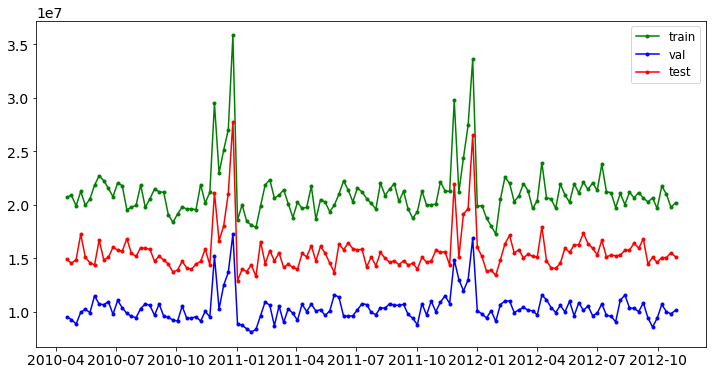

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_train_window.index, y_train_window, 'g.-', label='train')
ax.plot(y_val_window.index, y_val_window, 'b.-', label='val')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='test')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(y_test_window.index, y_test_window, 'r.', label='actual')
ax.legend();

In [ ]:
X_train_window, y_train_window

In [12]:
model = keras.models.Sequential([keras.layers.LSTM(20, return_sequences=True, input_shape=(n_prev, 1)), 
                                 keras.layers.LSTM(20, return_sequences=True), 
                                 keras.layers.TimeDistributed(keras.layers.Dense(1))]) 




model.compile(optimizer='rmsprop', loss='mse')

In [13]:
n = 100

model = keras.Sequential()
model.add(keras.layers.LSTM(n, input_shape=(n_prev, 1), return_sequences=True)) # 1 is num of variables to predict on
model.add(keras.layers.LSTM(n, return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [14]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.fit(X_train_window, y_train_window, epochs=300, batch_size=16, validation_data=(X_val_window, y_val_window)) 



Epoch 1/300
9/9 [==============================] - 1s 141ms/step - loss: 453468821127168.0000 - val_loss: 109432931352576.0000
Epoch 2/300
9/9 [==============================] - 0s 12ms/step - loss: 453468519137280.0000 - val_loss: 109432797134848.0000
Epoch 3/300
9/9 [==============================] - 0s 12ms/step - loss: 453468317810688.0000 - val_loss: 109432763580416.0000
Epoch 4/300
9/9 [==============================] - 0s 11ms/step - loss: 453468217147392.0000 - val_loss: 109432721637376.0000
Epoch 5/300
9/9 [==============================] - 0s 11ms/step - loss: 453468217147392.0000 - val_loss: 109432696471552.0000
Epoch 6/300
9/9 [==============================] - 0s 11ms/step - loss: 453468183592960.0000 - val_loss: 109432671305728.0000
Epoch 7/300
9/9 [==============================] - 0s 11ms/step - loss: 453468116484096.0000 - val_loss: 109432654528512.0000
Epoch 8/300
9/9 [==============================] - 0s 11ms/step - loss: 453468049375232.0000 - val_loss: 109432637751

In [15]:
y_pred = model.predict(X_test_window)

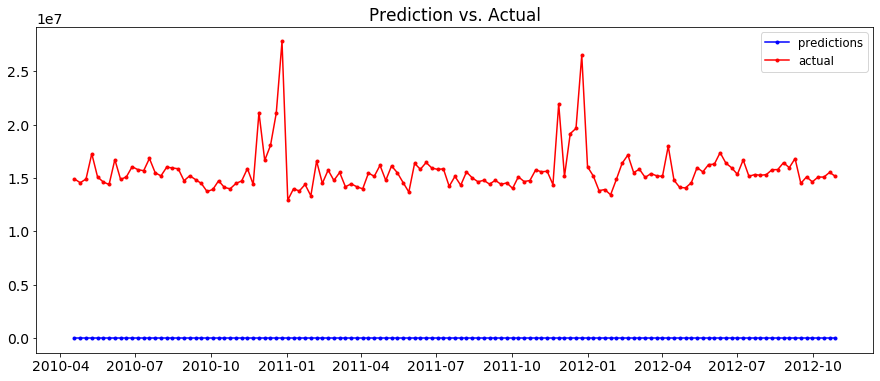

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
ax.legend()
ax.set_title('Prediction vs. Actual');

In [ ]:
y_pred

In [18]:
X_test_window

array([[[16949557.13000003],
        [15527423.02000002],
        [14904971.82999999],
        ...,
        [14034991.80999999],
        [16483324.48      ],
        [15761521.46999999]],

       [[15527423.02000002],
        [14904971.82999999],
        [14857999.26999999],
        ...,
        [16483324.48      ],
        [15761521.46999999],
        [14906580.86      ]],

       [[14904971.82999999],
        [14857999.26999999],
        [15453439.02999999],
        ...,
        [15761521.46999999],
        [14906580.86      ],
        [14555150.93000003]],

       ...,

       [[15310966.89999999],
        [15771052.76000002],
        [15789121.06999999],
        ...,
        [15101210.08000001],
        [14635362.29999998],
        [15089821.07      ]],

       [[15771052.76000002],
        [15789121.06999999],
        [16433747.40999999],
        ...,
        [14635362.29999998],
        [15089821.07      ],
        [15084852.99999999]],

       [[15789121.06999999],
        [1643